# Model of auxotrophic communities with mutations in update and production rates of amino acids

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))


---

## Load data

In [2]:
fit_pars = {} #dictionary to store fit parameters

df = pd.read_csv('data.csv')
df['rel_range'] = df['dP_patch']/df['dT_patch']
df.head(n=9)



,Condition,Rep,Ratio,Width,dT_patch,dP_patch,rel_range
0,A,1,0.260160,98.019242,9.982812,31.874861,3.192974
1,B,1,0.420748,157.745055,7.487109,6.117064,0.817013
2,C,1,0.590506,-0.064086,7.487109,11.631545,1.553543
3,D,1,0.625429,293.174008,8.314437,4.991406,0.600330
4,E,1,0.189678,805.362453,119.452271,231.705899,1.939736
5,F,1,0.386470,852.126212,125.763148,148.161343,1.178098
6,G,1,0.411337,824.371877,114.111317,162.914291,1.427679
7,H,1,0.404812,873.116202,132.916806,135.954874,1.022857
8,WT,1,0.544112,1083.906711,184.888467,720.857747,3.898879


In [3]:
def report_data(df, condition):
    df_sum = df[df['Condition']==condition]
    
    rel_growth = df_sum["Width"].mean()  / df.loc[df['Condition']=='WT']['Width'].mean() 
    sector_ratio = df_sum['dP_patch'].mean() / df_sum['dT_patch'].mean()
    
    print(f"Community {condition:s}: f(dT) = {df_sum['Ratio'].mean() :.2f}, rel. growth = {rel_growth:.2f}, sectors dT = {df_sum['dT_patch'].mean() :.2f}um, sectors dP = {df_sum['dP_patch'].mean() :.2f}um,  sector ratio = {sector_ratio:.2f}")
    return None

report_data(df, 'WT')

Community WT: f(dT) = 0.54, rel. growth = 1.00, sectors dT = 184.89um, sectors dP = 720.86um,  sector ratio = 3.90


---

### Fit cost function

In [4]:
def fit_1D(x, y_data, y_model):
    
    #check if y data is numpy array
    if isinstance(y_data, np.ndarray):
        delta = (y_model[np.newaxis,:] - y_data[:,np.newaxis])
        L2_norm = (delta**2).sum(axis=0)
    else:
        delta = y_model[np.newaxis,:] - y_data
        L2_norm = (delta**2)
    
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]
    fitted_y = y_model[min_idx]
    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    return (fitted_x, fitted_y)    

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
      
    delta1 = (z1[:, :, np.newaxis] - z1_data[np.newaxis, np.newaxis, :])/z1_data[np.newaxis, np.newaxis, :]
    L2_norm1 = (delta1**2).sum(axis=2)

    delta2 = (z2[:, :, np.newaxis] - z2_data[np.newaxis, np.newaxis, :])/z2_data[np.newaxis, np.newaxis, :]
    L2_norm2 = (delta2**2).sum(axis=2)

    L2_norm_comb = np.log10(L2_norm1 + L2_norm2)


    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)


def fit_3D(x, y, z1, z2, z3, z1_data, z2_data, z3_data):
      
    delta1 = (z1[:, :, np.newaxis] - z1_data[np.newaxis, np.newaxis, :])/z1_data[np.newaxis, np.newaxis, :]
    L2_norm1 = (delta1**2).sum(axis=2)

    delta2 = (z2[:, :, np.newaxis] - z2_data[np.newaxis, np.newaxis, :])/z2_data[np.newaxis, np.newaxis, :]
    L2_norm2 = (delta2**2).sum(axis=2)
    
    delta3 = (z3[:, :, np.newaxis] - z3_data[np.newaxis, np.newaxis, :])/z3_data[np.newaxis, np.newaxis, :]
    L2_norm3 = (delta3**2).sum(axis=2)

    L2_norm_comb = np.log10(L2_norm1 + L2_norm2 + L2_norm3)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,4,figsize=(20,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].contour(x, y, z3, levels=[z3_data.mean()], colors='c')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')


    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].contour(x, y, z3, levels=[z3_data.mean()], colors='c')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    im2 = axs[2].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[2])
    axs[2].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[2].contour(x, y, z2, levels=[z2_data.mean()], colors='c')
    axs[2].contour(x, y, z3, levels=[z3_data.mean()], colors='r')
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')

    im3 = axs[3].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im3, ax=axs[3])
    axs[3].axvline(x=xfit, color='k', linestyle='--')
    axs[3].axhline(y=yfit, color='k', linestyle='--')


    return (xfit, yfit)


---

## Fit Leakage rates based on community A

Pro leakage = 3.43e-06 (original = 1.59e-05), Trp leakage = 3.76e-07 (original = 6.04e-07)
Community A: f(dT) = 0.26, rel. growth = 0.09, sectors dT = 9.98um, sectors dP = 31.87um,  sector ratio = 3.19


Frequency dT = 0.26
Clustering dT = 0.89, Clustering dP = 0.99
Growth relative to WT = 0.09
Growth defect spatial community = 0.93
mu_max dP = 0.45, mu_max dT = 0.17
range dP = 10.45um, range dT = 2.48um


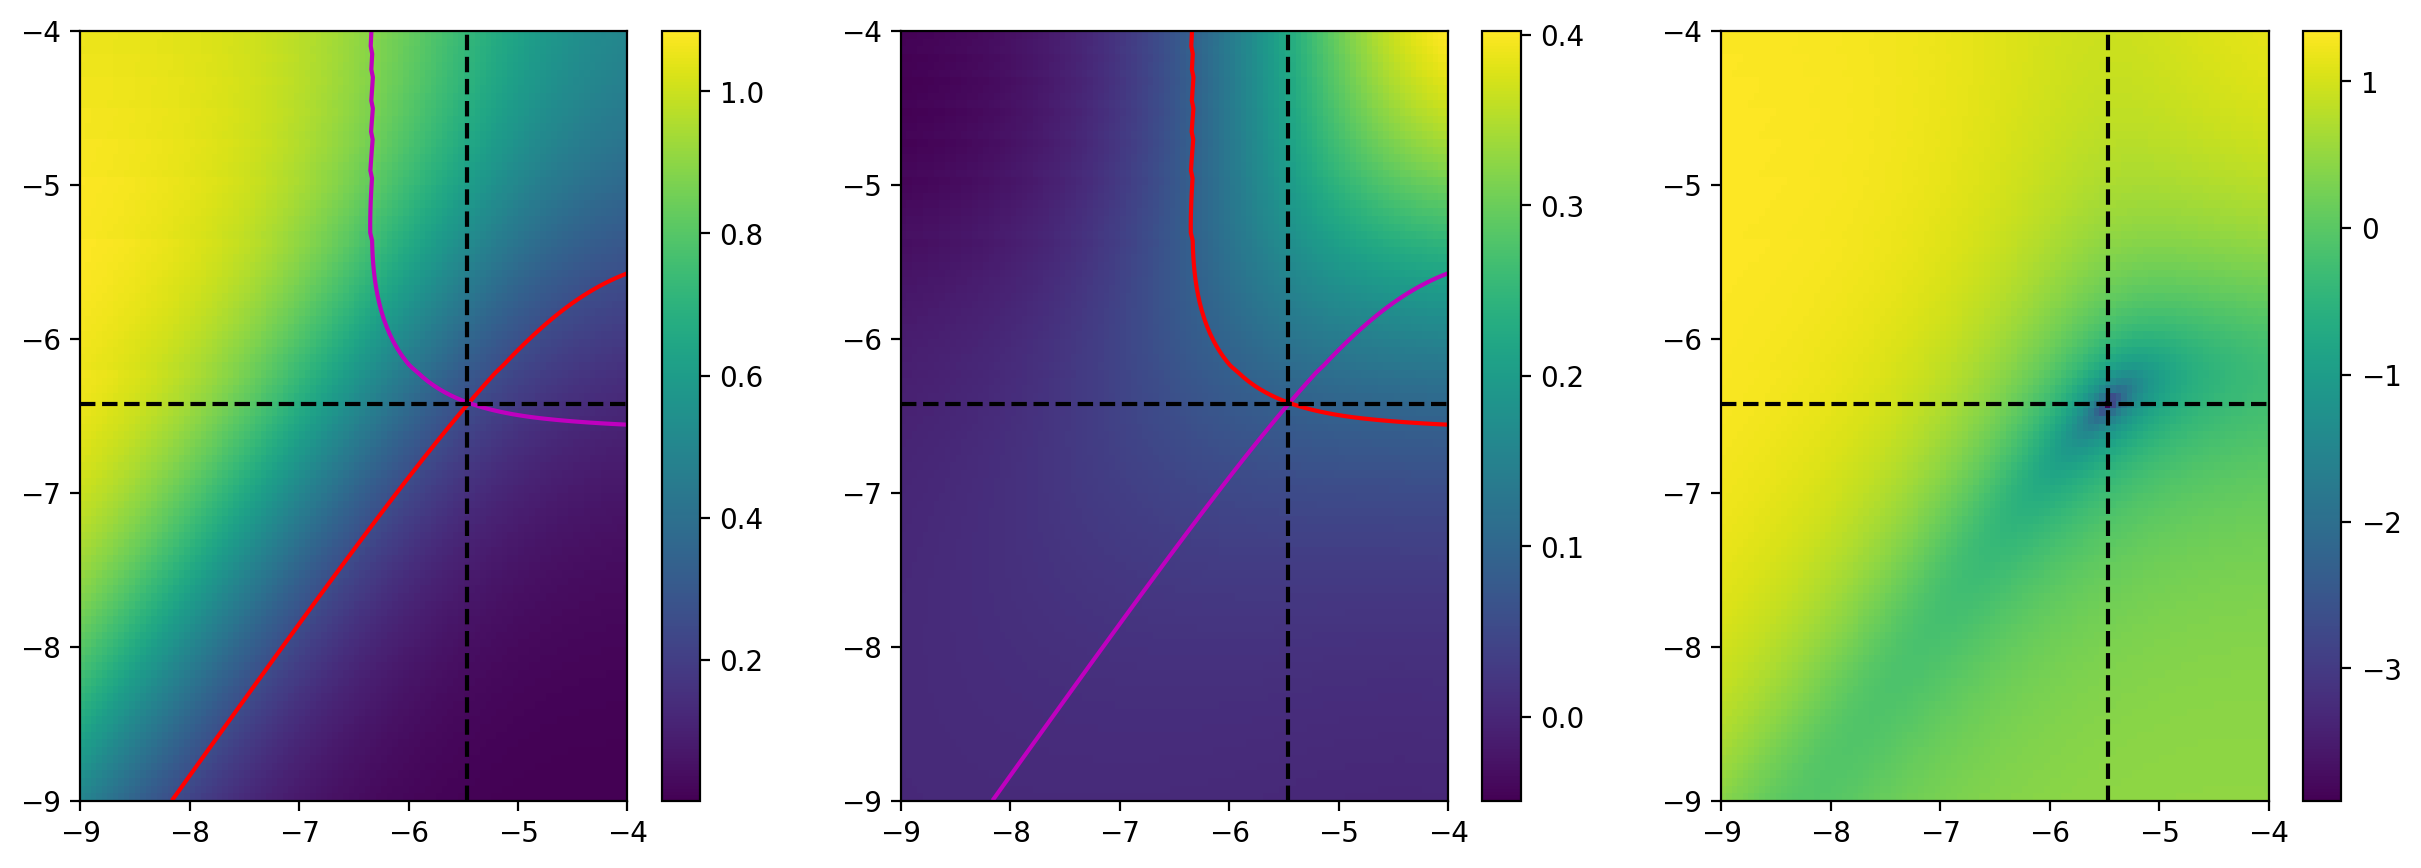

In [5]:
wt_community = community()

lPro = np.linspace(-9,-4,100)
lTrp = np.linspace(-9,-4,100)

xmat, ymat = np.meshgrid(lPro, lTrp)

eq_data = df.loc[df['Condition']=='A']['Ratio'].values 
growth_data = df.loc[df['Condition']=='A']['Width'].mean() / df.loc[df['Condition']=='WT']['Width'].mean() 

community_A = community(lPro=10**xmat, lTrp=10**ymat)

x = lPro
y = lTrp
z1 = community_A.eq
z1_data = eq_data

z2 = community_A.rel_growth_wt
z2_data = np.atleast_1d(np.array(growth_data))

xfit, yfit = fit_2D(x, y, z1, z2, z1_data, z2_data)

lPro_fit = 10**xfit
lTrp_fit = 10**yfit

print(f"Pro leakage = {lPro_fit:.3g} (original = {wt_community.lPro:.3g}), Trp leakage = {lTrp_fit:.3g} (original = {wt_community.lTrp:.3g})")
report_data(df, 'A')

print("\n")
community_A_fit = community(lPro=lPro_fit, lTrp=lTrp_fit)
community_A_fit.report_properties()

fit_pars['lPro'] = lPro_fit
fit_pars['lTrp'] = lTrp_fit

---
## Characterize putP using community B

### fit increase in Pro uptake by putP over expression (assuming no cost)

First we fit increase in uptake base on change in growth range

/Users/simonvanvliet/switchdrive/Biozentrum/Code/SchaerliLab/community.py:182: RuntimeWarning: divide by zero encountered in divide
  self.rel_growth_wm = growth / growth_wm


Text(0, 0.5, 'eq fraction')

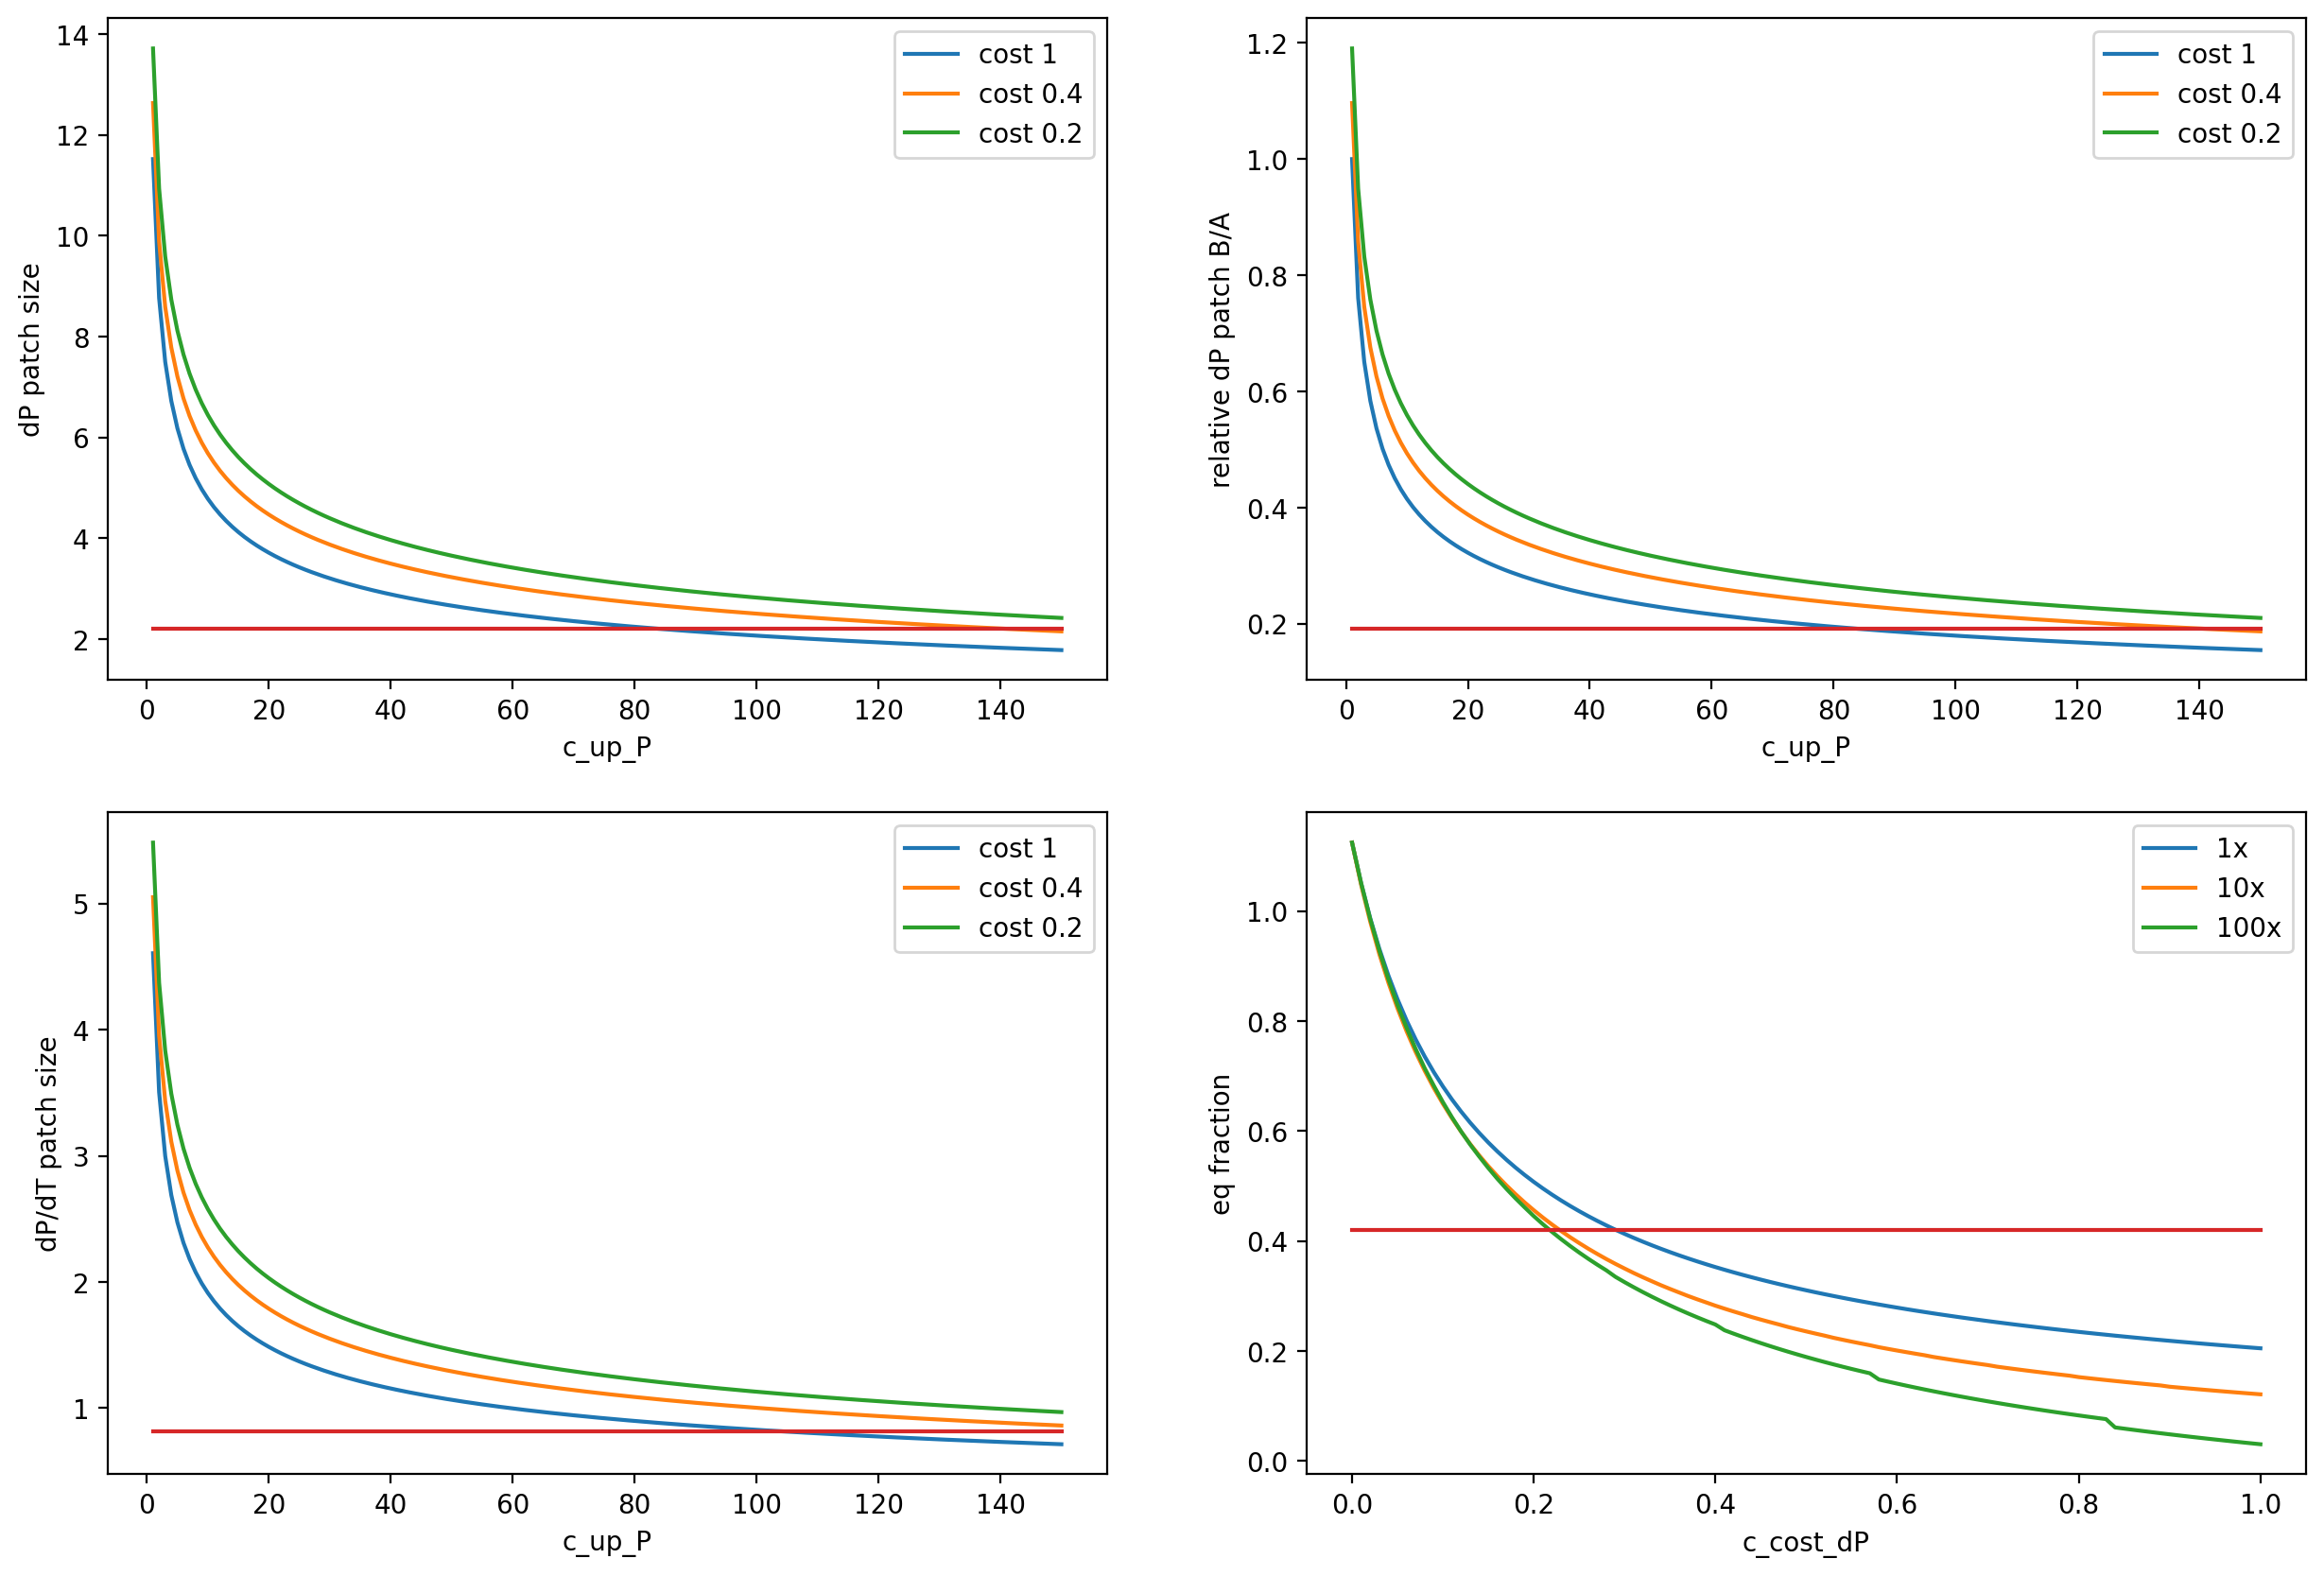

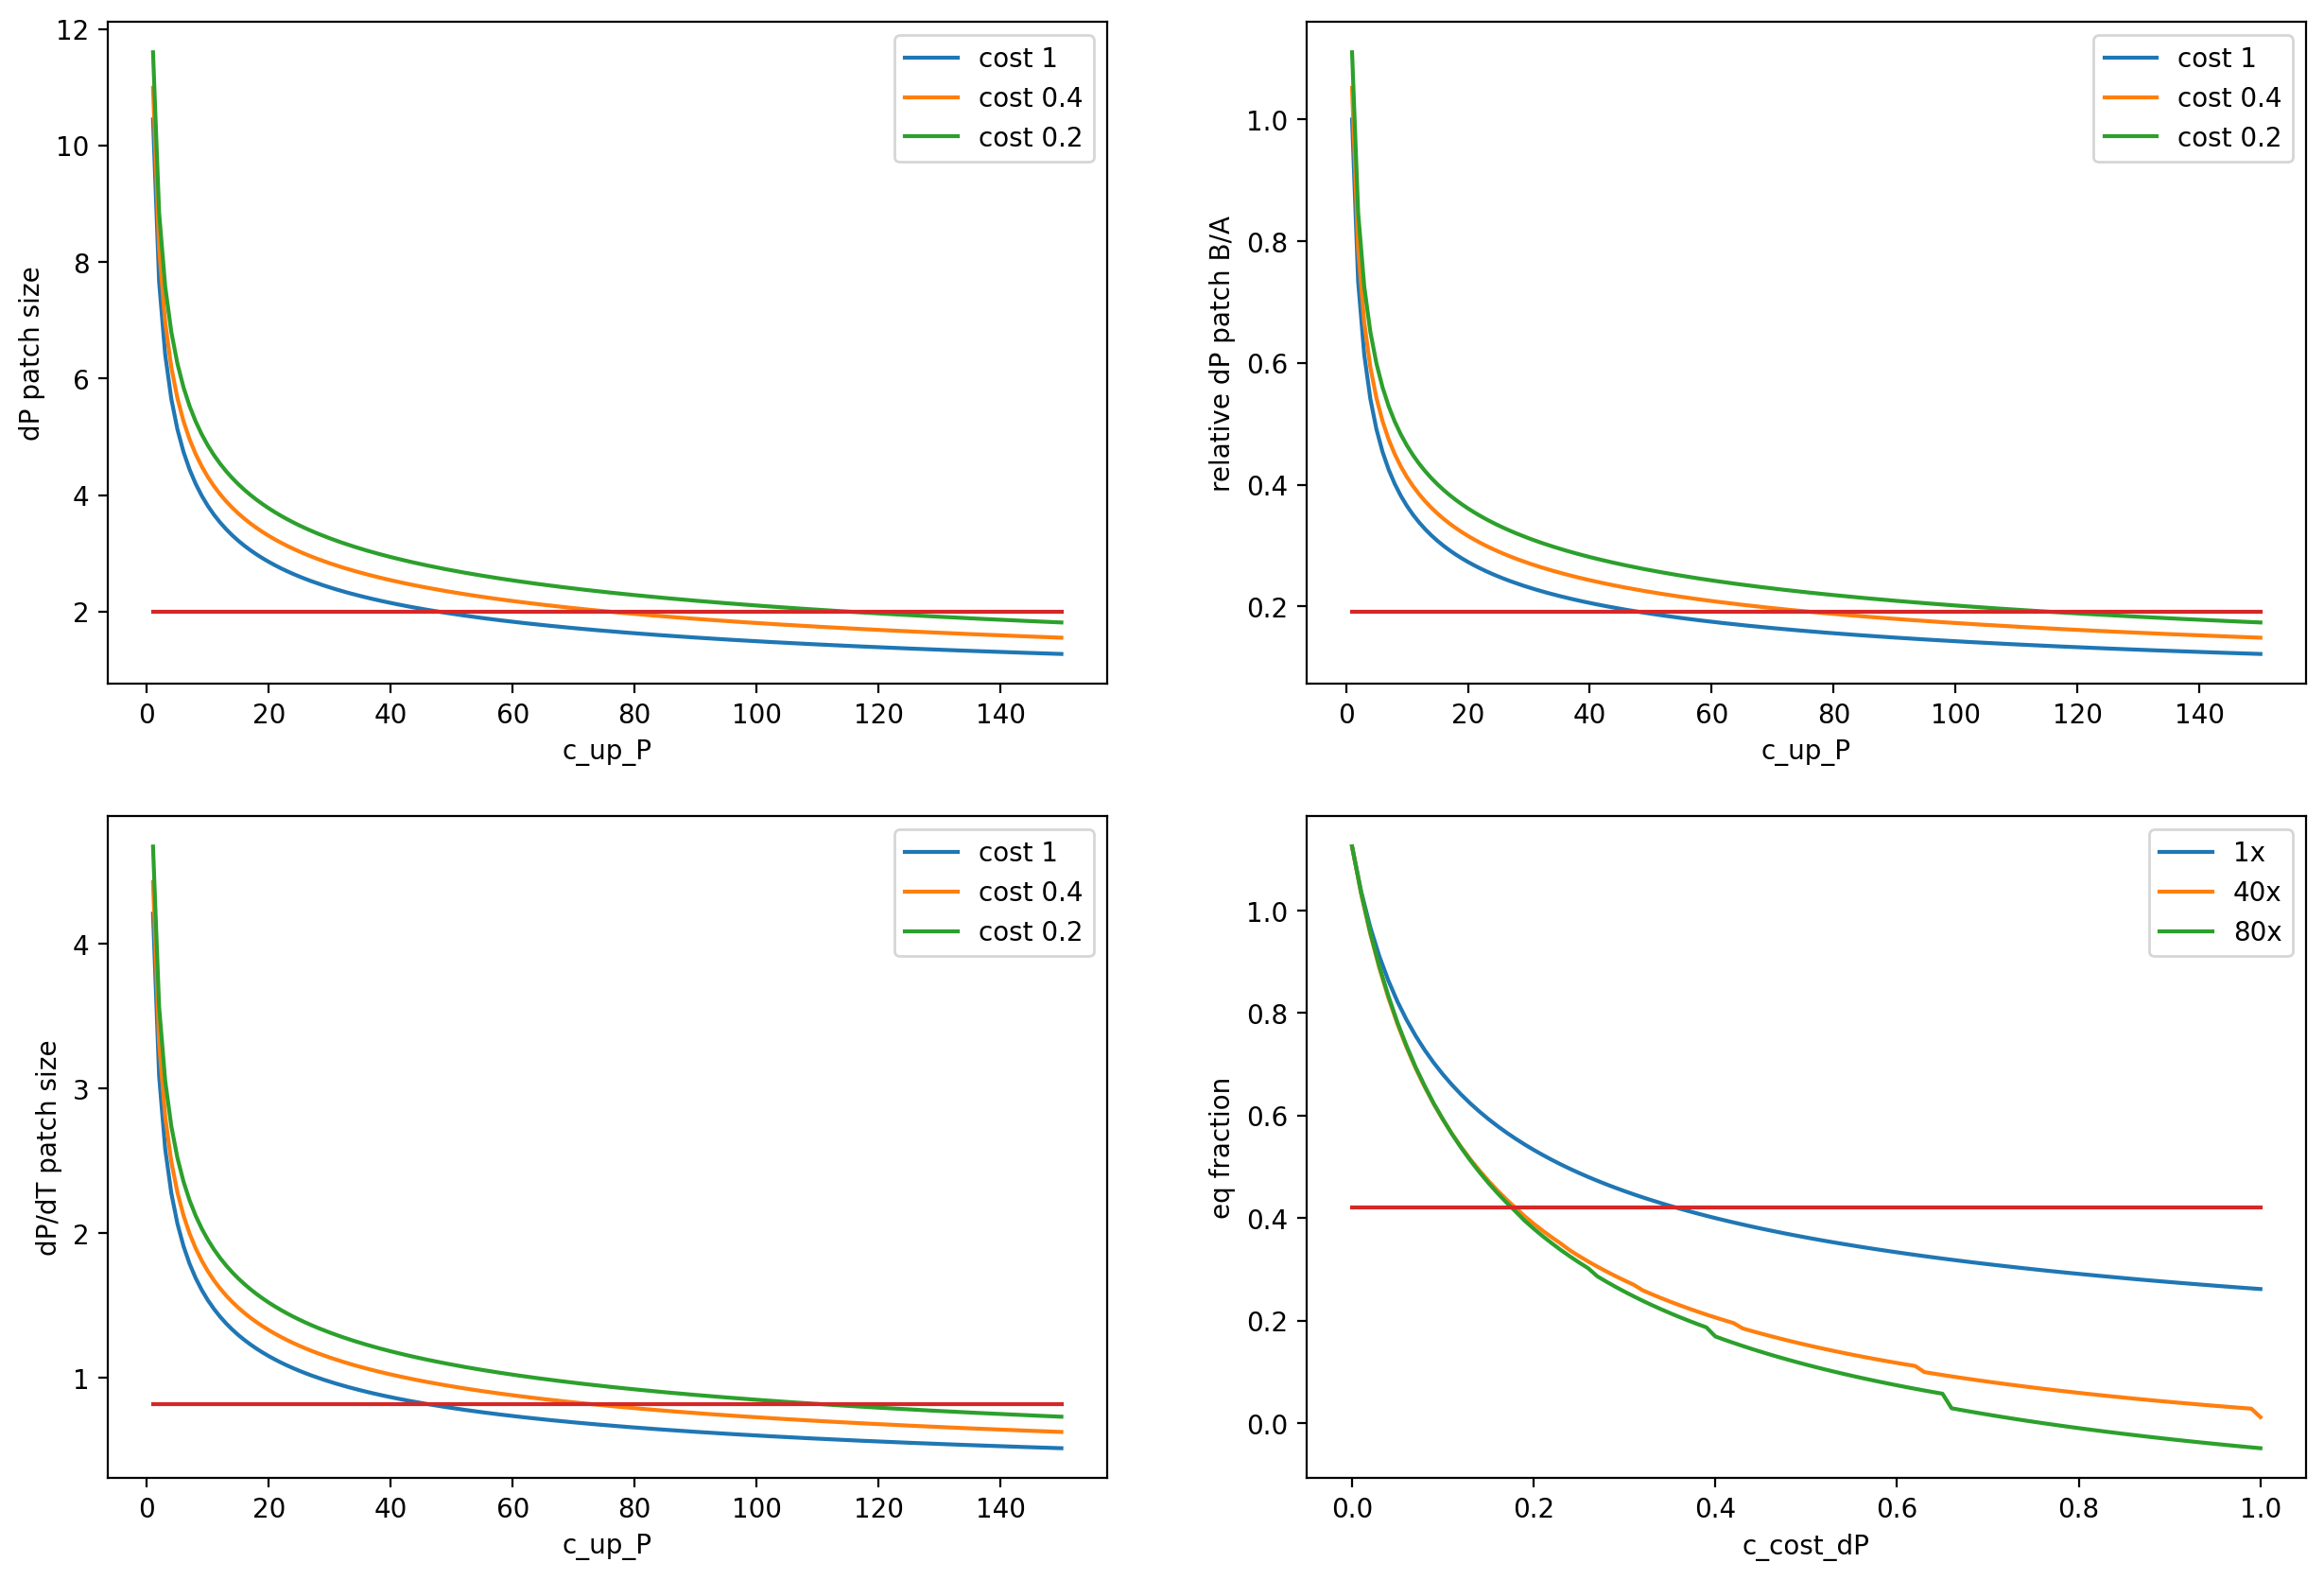

In [18]:
# get baseline community
community_A = community()

#get measured value
dPpatch_dataA = df.loc[df['Condition']=='A']['dP_patch'].values.mean()
dPpatch_data = df.loc[df['Condition']=='B']['dP_patch'].values.mean()
rel_dPdT_patch_data = df.loc[df['Condition']=='B']['rel_range'].values.mean() 
rel_dP_patch_data = df.loc[df['Condition']=='B']['dP_patch'].mean() / df.loc[df['Condition']=='A']['dP_patch'].mean()

eq_data = df.loc[df['Condition']=='B']['Ratio'].values.mean()


#calc model predictions with varying cost for putP
c_up_P = np.linspace(1,150,150)
community_B1 = community(c_up_P=c_up_P, c_cost_dP=1)
community_B2 = community(c_up_P=c_up_P, c_cost_dP=0.4)
community_B3 = community(c_up_P=c_up_P, c_cost_dP=0.2)


fig, axs = plt.subplots(2,2,figsize=(15,10))

modifier = dPpatch_dataA / community_A.rangeP

axs[0][0].plot(c_up_P, community_B1.rangeP, label='cost 1')
axs[0][0].plot(c_up_P, community_B2.rangeP, label='cost 0.4')
axs[0][0].plot(c_up_P, community_B3.rangeP, label='cost 0.2')
axs[0][0].plot(c_up_P, np.ones_like(c_up_P)*dPpatch_data/modifier)
axs[0][0].legend()
axs[0][0].set_xlabel('c_up_P')
axs[0][0].set_ylabel('dP patch size')

axs[0][1].plot(c_up_P, community_B1.rangeP/community_A.rangeP, label='cost 1')
axs[0][1].plot(c_up_P, community_B2.rangeP/community_A.rangeP, label='cost 0.4')
axs[0][1].plot(c_up_P, community_B3.rangeP/community_A.rangeP, label='cost 0.2')
axs[0][1].legend()

axs[0][1].plot(c_up_P, np.ones_like(c_up_P)*rel_dP_patch_data)
axs[0][1].set_xlabel('c_up_P')
axs[0][1].set_ylabel('relative dP patch B/A')

axs[1][0].plot(c_up_P, community_B1.rangeP/community_B1.rangeT, label='cost 1')
axs[1][0].plot(c_up_P, community_B2.rangeP/community_B2.rangeT, label='cost 0.4')
axs[1][0].plot(c_up_P, community_B3.rangeP/community_B3.rangeT, label='cost 0.2')
axs[1][0].legend()
axs[1][0].plot(c_up_P, np.ones_like(c_up_P)*rel_dPdT_patch_data)
axs[1][0].set_xlabel('c_up_P')
axs[1][0].set_ylabel('dP/dT patch size')

c_cost_dP = np.linspace(0,1,101)

community_B1 = community(c_up_P=1, c_cost_dP=c_cost_dP)
community_B2 = community(c_up_P=10, c_cost_dP=c_cost_dP)
community_B3 = community(c_up_P=100, c_cost_dP=c_cost_dP)

axs[1][1].plot(c_cost_dP, community_B1.eq, label='1x')
axs[1][1].plot(c_cost_dP, community_B2.eq, label='10x')
axs[1][1].plot(c_cost_dP, community_B3.eq, label='100x')
axs[1][1].plot(c_cost_dP, np.ones_like(c_cost_dP)*eq_data)
axs[1][1].legend()
axs[1][1].set_xlabel('c_cost_dP')
axs[1][1].set_ylabel('eq fraction')


#with fitted leakage rates
#calc model predictions with varying cost for putP
c_up_P = np.linspace(1,150,150)

community_B1 = community(c_up_P=c_up_P, c_cost_dP=1, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])
community_B2 = community(c_up_P=c_up_P, c_cost_dP=0.4, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])
community_B3 = community(c_up_P=c_up_P, c_cost_dP=0.2, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])
community_A_fit = community(lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])


fig, axs = plt.subplots(2,2,figsize=(15,10))

modifier = dPpatch_dataA / community_A_fit.rangeP

axs[0][0].plot(c_up_P, community_B1.rangeP, label='cost 1')
axs[0][0].plot(c_up_P, community_B2.rangeP, label='cost 0.4')
axs[0][0].plot(c_up_P, community_B3.rangeP, label='cost 0.2')
axs[0][0].plot(c_up_P, np.ones_like(c_up_P)*dPpatch_data/modifier)
axs[0][0].legend()
axs[0][0].set_xlabel('c_up_P')
axs[0][0].set_ylabel('dP patch size')

axs[0][1].plot(c_up_P, community_B1.rangeP/community_A_fit.rangeP, label='cost 1')
axs[0][1].plot(c_up_P, community_B2.rangeP/community_A_fit.rangeP, label='cost 0.4')
axs[0][1].plot(c_up_P, community_B3.rangeP/community_A_fit.rangeP, label='cost 0.2')
axs[0][1].legend()
axs[0][1].plot(c_up_P, np.ones_like(c_up_P)*rel_dP_patch_data)
axs[0][1].set_xlabel('c_up_P')
axs[0][1].set_ylabel('relative dP patch B/A')

axs[1][0].plot(c_up_P, community_B1.rangeP/community_B1.rangeT, label='cost 1')
axs[1][0].plot(c_up_P, community_B2.rangeP/community_B2.rangeT, label='cost 0.4')
axs[1][0].plot(c_up_P, community_B3.rangeP/community_B3.rangeT, label='cost 0.2')
axs[1][0].legend()
axs[1][0].plot(c_up_P, np.ones_like(c_up_P)*rel_dPdT_patch_data)
axs[1][0].set_xlabel('c_up_P')
axs[1][0].set_ylabel('dP/dT patch size')

c_cost_dP = np.linspace(0,1,101)

community_B1 = community(c_up_P=1, c_cost_dP=c_cost_dP, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])
community_B2 = community(c_up_P=40, c_cost_dP=c_cost_dP, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])
community_B3 = community(c_up_P=80, c_cost_dP=c_cost_dP, lPro=fit_pars['lPro'], lTrp=fit_pars['lTrp'])

axs[1][1].plot(c_cost_dP, community_B1.eq, label='1x')
axs[1][1].plot(c_cost_dP, community_B2.eq, label='40x')
axs[1][1].plot(c_cost_dP, community_B3.eq, label='80x')
axs[1][1].plot(c_cost_dP, np.ones_like(c_cost_dP)*eq_data)
axs[1][1].legend()
axs[1][1].set_xlabel('c_cost_dP')
axs[1][1].set_ylabel('eq fraction')


---

## Report fitting results

In [88]:
print(fit_pars)
#write fitted parameters to csv file
with open('fit_pars.csv', 'w') as f:
    for key in fit_pars.keys():
        f.write("%s,%s\n"%(key,fit_pars[key]))

{'lPro': 3.430469286314919e-06, 'lTrp': 3.764935806792471e-07, 'c_up_P': 120.60101010101009, 'cost_putP': 0.175, 'c_prod_T': 22.0, 'c_prod_P': 2.909090909090909, 'c_up_P2': 126.63131313131312, 'cost_putP2': 0.335}
